# Epidemic threshold

We're familiar with the idea that some diseases are more infectious than others. In real-world epidemics this is emobodied in the basic case reproduction number $R_0$, which counts the number of other infections arising on average from every infection. In modelling it is embodied in $p_{\mathit{infect}}$, the probability that a contact leads to an infection.

But how infectious does a disease have to be to cause an epidemic? &ndash; that is to say, to create infection in a sizeable fraction of a population?

Clearly these two ideas are related: a disease that passes eassily between people will be more likely to pass to more people. But it turns out that the relationship isn't as simple as we might expect. It's affected by a number of factors, including the disease parameters and the topology of the network &ndash; in other words, by the disease *and* the environment in which it finds itself. This is important: we can't do anything about the basic infectiousness of a disease since that's defined by its biology, but the significance of topology opens-up the possibilty of countermeasures at a population level. 

Looking back at the SIR model on an ER network, we see patterns in the way it spreads. For very low values of $\langle k \rangle$, the mean degree of the network, the epidemic never really "gets going". We can think of this as being what happens when the disease begins in population that's too disconnected to spread the disease before the infected individuals recover (or die). This is the other extreme to the fully connected network where *all* connections were in play and the propagation of the disease depended solely on the relationship between the rates of infection and recovery.

Let's ask a different qiuestion, though. If we fix the topology but change the infectivity, what happens to the numnbers of people infected? We already know that in the fully-mixed case a very small change in infectivity results in a massive change in the size of the epidemic. But that was in a somewhat unrealistic case. What happens if we place the disease on a network and see how it propagates?

## The epidemic threshold of an ER network

Let's look at the case for an ER network, the simplest model we have. (We've already accepted that it's not a great model of human contact networks, but we'll refine this later.)


In [9]:
import numpy
import networkx
import epyc
import epydemic
import pandas

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import seaborn

In [4]:
N = 10000
kmean = 40
g = networkx.gnp_random_graph(N, (kmean + 0.0) / N)

In [17]:
lab = epyc.Lab()
lab[epydemic.SIR.P_INFECTED] = 0.001
lab[epydemic.SIR.P_REMOVE] = 0.002
lab[epydemic.SIR.P_INFECT] = numpy.linspace(0.00001, 0.0002, num=50)

In [18]:
m = epydemic.SIR()
e = epydemic.SynchronousDynamics(m, g)
rc = lab.runExperiment(e)

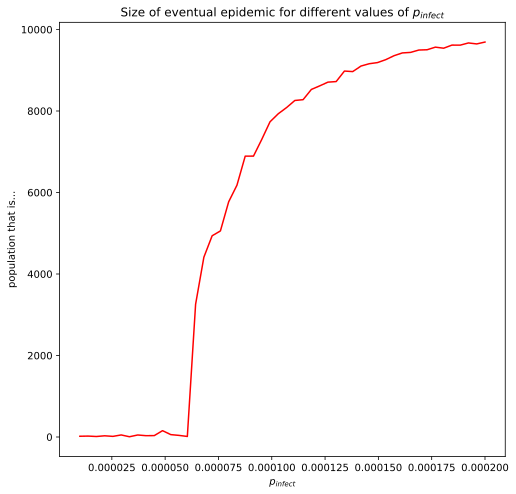

In [24]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

# plot the size of the removed population
df = lab.dataframe()
ax.plot(df[epydemic.SIR.P_INFECT], df[epydemic.SIR.REMOVED], 'r-')
ax.set_xlabel('$p_{\\mathit{infect}}$')
ax.set_ylabel('population that is...')
ax.set_title('Size of eventual epidemic for different values of $p_{\\mathit{infect}}$')

plt.show()